# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [21]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import mean as Fmean
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

### dataset basic info

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
user_log.count()

286500

In [6]:
user_log.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### check unique values for some columns

In [7]:
user_log.select("auth").dropDuplicates().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

In [8]:
user_log.select("level").dropDuplicates().collect()

[Row(level='free'), Row(level='paid')]

In [9]:
user_log.select("method").dropDuplicates().collect()

[Row(method='PUT'), Row(method='GET')]

In [10]:
user_log.select("page").dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [11]:
user_log.select("status").dropDuplicates().collect()

[Row(status=307), Row(status=404), Row(status=200)]

### How columns are related with other cplumns

In [12]:
user_log.filter(user_log.auth=="Logged Out").select(["auth", "page", "method"]).dropDuplicates().collect()

[Row(auth='Logged Out', page='Error', method='GET'),
 Row(auth='Logged Out', page='Help', method='GET'),
 Row(auth='Logged Out', page='Home', method='GET'),
 Row(auth='Logged Out', page='Login', method='PUT'),
 Row(auth='Logged Out', page='About', method='GET')]

In [13]:
user_log.filter(user_log.auth=="Guest").select(["auth", "page", "method"]).dropDuplicates().collect()

[Row(auth='Guest', page='Help', method='GET'),
 Row(auth='Guest', page='Register', method='GET'),
 Row(auth='Guest', page='Home', method='GET'),
 Row(auth='Guest', page='Submit Registration', method='PUT'),
 Row(auth='Guest', page='Error', method='GET'),
 Row(auth='Guest', page='About', method='GET')]

In [14]:
user_log.filter(user_log.auth=="Cancelled").select(["auth", "page", "method"]).dropDuplicates().collect()

[Row(auth='Cancelled', page='Cancellation Confirmation', method='GET')]

In [15]:
user_log.filter(user_log.auth=="Guest").select(["userId"]).dropDuplicates().collect()

[Row(userId='')]

In [16]:
user_log.filter(user_log.auth=="Logged Out").select(["userId"]).dropDuplicates().collect()

[Row(userId='')]

In [17]:
user_log.filter(user_log.auth=="Logged In").select(["auth", "page", "method"]).dropDuplicates().collect()

[Row(auth='Logged In', page='Thumbs Up', method='PUT'),
 Row(auth='Logged In', page='Save Settings', method='PUT'),
 Row(auth='Logged In', page='Downgrade', method='GET'),
 Row(auth='Logged In', page='Add to Playlist', method='PUT'),
 Row(auth='Logged In', page='Add Friend', method='PUT'),
 Row(auth='Logged In', page='Submit Downgrade', method='PUT'),
 Row(auth='Logged In', page='About', method='GET'),
 Row(auth='Logged In', page='Cancel', method='PUT'),
 Row(auth='Logged In', page='Home', method='GET'),
 Row(auth='Logged In', page='Logout', method='PUT'),
 Row(auth='Logged In', page='Roll Advert', method='GET'),
 Row(auth='Logged In', page='Error', method='GET'),
 Row(auth='Logged In', page='NextSong', method='PUT'),
 Row(auth='Logged In', page='Settings', method='GET'),
 Row(auth='Logged In', page='Submit Upgrade', method='PUT'),
 Row(auth='Logged In', page='Thumbs Down', method='PUT'),
 Row(auth='Logged In', page='Upgrade', method='GET'),
 Row(auth='Logged In', page='Help', method='

when users logged out, they can Error, Help, Home, Login, About. records with "Logged Out" has no userId

guests can Help, Register, Home, submit registration, error, about. records with "Guests" has no userId

when users cancel the service, auth=Cancelled, page="Cancellation Confirmation"

In [18]:
user_log.filter(user_log.method=="PUT").select(["page", "method"]).dropDuplicates().collect()

[Row(page='Add Friend', method='PUT'),
 Row(page='Logout', method='PUT'),
 Row(page='Submit Upgrade', method='PUT'),
 Row(page='Add to Playlist', method='PUT'),
 Row(page='Cancel', method='PUT'),
 Row(page='Submit Downgrade', method='PUT'),
 Row(page='Login', method='PUT'),
 Row(page='Save Settings', method='PUT'),
 Row(page='Thumbs Down', method='PUT'),
 Row(page='Submit Registration', method='PUT'),
 Row(page='NextSong', method='PUT'),
 Row(page='Thumbs Up', method='PUT')]

In [19]:
user_log.filter(user_log.method=="GET").select(["page", "method"]).dropDuplicates().collect()

[Row(page='About', method='GET'),
 Row(page='Settings', method='GET'),
 Row(page='Help', method='GET'),
 Row(page='Downgrade', method='GET'),
 Row(page='Register', method='GET'),
 Row(page='Upgrade', method='GET'),
 Row(page='Error', method='GET'),
 Row(page='Cancellation Confirmation', method='GET'),
 Row(page='Home', method='GET'),
 Row(page='Roll Advert', method='GET')]

when could users receive 404

In [20]:
user_log.filter(user_log.status==404).select(["page", "method"]).dropDuplicates().collect()

[Row(page='Error', method='GET')]

how often can users meet 404

In [21]:
user_log.filter(user_log.status==404).count()

258

when could users receive 307

In [22]:
user_log.filter(user_log.status==307).select(["page", "method"]).dropDuplicates().collect()

[Row(page='Add Friend', method='PUT'),
 Row(page='Logout', method='PUT'),
 Row(page='Submit Upgrade', method='PUT'),
 Row(page='Cancel', method='PUT'),
 Row(page='Submit Downgrade', method='PUT'),
 Row(page='Login', method='PUT'),
 Row(page='Save Settings', method='PUT'),
 Row(page='Thumbs Down', method='PUT'),
 Row(page='Submit Registration', method='PUT'),
 Row(page='Thumbs Up', method='PUT')]

how often users can meet 307

In [23]:
user_log.filter(user_log.status==307).count()

26430

### check None, empty, nan values

In [12]:
user_log.select([count(when(isnan(c), c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
user_log.select([count(when(user_log[c]=='', c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


In [14]:
user_log.select([count(when(user_log[c].isNull(), c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [15]:
user_log.filter(user_log.userId=="").select(["page",'auth']).dropDuplicates().toPandas()

,page,auth
0,Submit Registration,Guest
1,Error,Logged Out
2,Login,Logged Out
3,Help,Logged Out
4,Error,Guest
5,Home,Guest
6,Help,Guest
7,Home,Logged Out
8,About,Logged Out
9,Register,Guest


when auth=="Logged In" or "Cancelled", we have userId

In [28]:
user_log.filter(user_log.userId=="").limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,


In [29]:
user_log.filter(user_log.song.isNotNull()).select(['page','auth']).dropDuplicates().toPandas()

,page,auth
0,NextSong,Logged In


**only records with page being NextSong have information for songs**

remove rows without userId

In [30]:
user_log = user_log.filter(user_log.userId!="")

check if rows have been removed

In [31]:
user_log.select([count(when(user_log[c].isNull(), c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


In [32]:
user_log.select([count(when(user_log[c]=='', c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
user_log.filter(user_log.auth=="Cancelled").limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Cancelled,Adriel,M,104,Mendoza,None,paid,"Kansas City, MO-KS",GET,Cancellation Confirmation,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
1,None,Cancelled,Diego,M,56,Mckee,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Cancellation Confirmation,1537167593000,540,None,200,1539033046000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
2,None,Cancelled,Mason,M,10,Hart,None,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125
3,None,Cancelled,Alexander,M,332,Garcia,None,paid,"Indianapolis-Carmel-Anderson, IN",GET,Cancellation Confirmation,1536817381000,508,None,200,1539375441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105
4,None,Cancelled,Kayla,F,273,Johnson,None,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",GET,Cancellation Confirmation,1538333829000,797,None,200,1539465584000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,17


In [34]:
user_log.filter(user_log.page=="Downgrade").limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Alexi,F,4,Warren,None,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
1,None,Logged In,Faigy,F,29,Howe,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Downgrade,1538211832000,248,None,200,1538373286000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95
2,None,Logged In,Faigy,F,115,Howe,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Downgrade,1538211832000,248,None,200,1538392612000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95
3,None,Logged In,Kael,M,46,Baker,None,paid,"Kingsport-Bristol-Bristol, TN-VA",GET,Downgrade,1533102330000,249,None,200,1538393618000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
4,None,Logged In,Faigy,F,125,Howe,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Downgrade,1538211832000,248,None,200,1538393664000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,95


In [35]:
user_log.count()

278154

In [36]:
user_log.select(["page", "userId", "ts"]).filter(user_log.userId=="125").collect()

[Row(page='NextSong', userId='125', ts=1539317144000),
 Row(page='NextSong', userId='125', ts=1539317481000),
 Row(page='NextSong', userId='125', ts=1539317711000),
 Row(page='NextSong', userId='125', ts=1539317914000),
 Row(page='NextSong', userId='125', ts=1539318124000),
 Row(page='NextSong', userId='125', ts=1539318515000),
 Row(page='NextSong', userId='125', ts=1539318728000),
 Row(page='NextSong', userId='125', ts=1539318906000),
 Row(page='Roll Advert', userId='125', ts=1539318917000),
 Row(page='Cancel', userId='125', ts=1539318918000),
 Row(page='Cancellation Confirmation', userId='125', ts=1539318918000)]

In [19]:
page_count = user_log.groupby("page").count().toPandas()
page_count

,page,count
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,14457
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,924


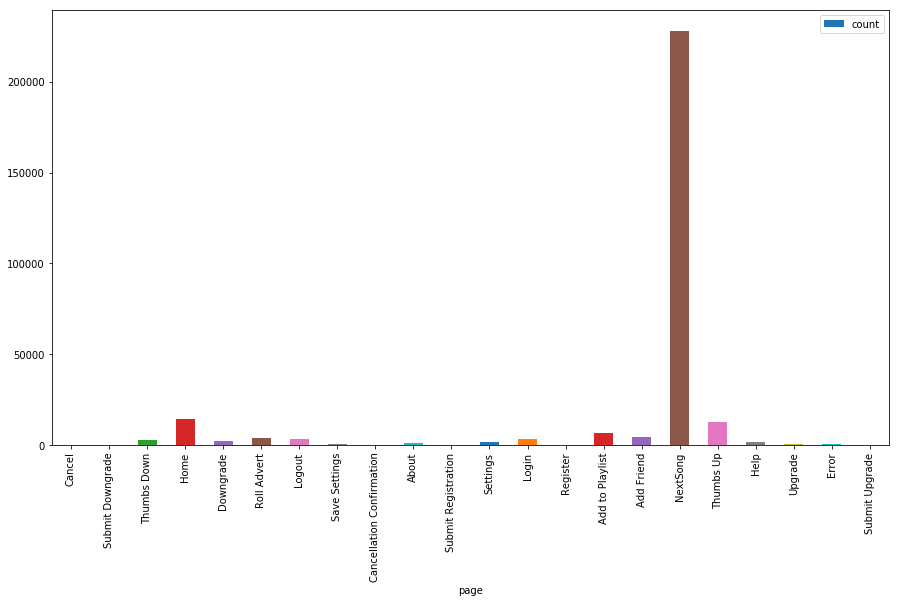

In [32]:

page_count.plot.bar(x='page', y='count', figsize=(15, 8))

In [33]:
hist = user_log.groupBy("userId").count().select("count").rdd.flatMap(lambda x: x).histogram(11)

In [37]:
hist

([6.0,
  881.0909090909091,
  1756.1818181818182,
  2631.2727272727275,
  3506.3636363636365,
  4381.454545454546,
  5256.545454545455,
  6131.636363636364,
  7006.727272727273,
  7881.818181818182,
  8756.909090909092,
  9632],
 [116, 47, 41, 9, 5, 3, 1, 1, 1, 1, 1])

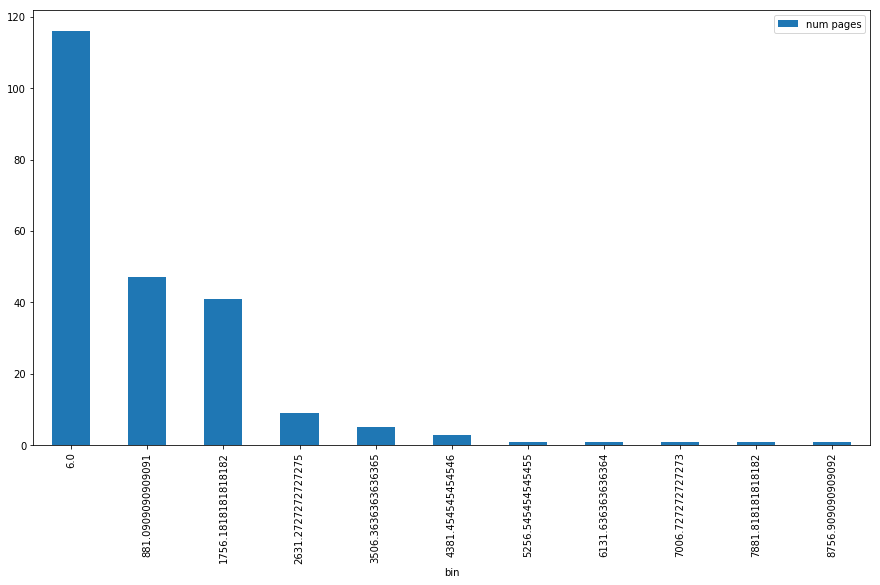

In [43]:
pd.DataFrame(
    list(zip(*hist)), 
    columns=['bin', 'num pages']
).set_index(
    'bin'
).plot(kind='bar', figsize=(15,8));

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [44]:
user_log = user_log.withColumn("Churn", when(user_log.page=="Cancellation Confirmation", 1).otherwise(0))
user_log = user_log.withColumn("Downgrade", when(user_log.page=="Downgrade", 1).otherwise(0))
user_log = user_log.withColumn("IsPaidUser", when(user_log.level=='paid', 1).otherwise(0))
user_log.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,Churn,Downgrade,IsPaidUser
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,1
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,1
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,1


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**features:**
1. Is a user ever downgraded
2. last login
3. total number of songs in all time
4. number of thumbs up in all time
5. number of thumbs down in all time
6. number of errors in all time
7. total number of songs in last week
8. number of thumbs up in last week
9. number of thumbs down in last week
10. number of errors in last week

In [45]:
user_log = user_log.withColumn("song", when(col("page")=="NextSong", 1).otherwise(0))
user_log = user_log.withColumn("thumbs_down", when(col("page")=="Thumbs Down", 1).otherwise(0))
user_log = user_log.withColumn("thumbs_up", when(col("page")=="Thumbs Up", 1).otherwise(0))
user_log = user_log.withColumn("error", when(col("page")=="Error", 1).otherwise(0))

max_ts = user_log.agg({"ts": "max"}).collect()[0].asDict()["max(ts)"]
user_log = user_log.withColumn("days_ago", (max_ts - col("ts"))/(1000*3600*24))
user_log = user_log.withColumn("song_last_week", when((col("days_ago")<7)&(col("page")=="NextSong"), 1).otherwise(0))
user_log = user_log.withColumn("error_last_week", when((col("days_ago")<7)&(col("page")=="Error"), 1).otherwise(0))
user_log = user_log.withColumn("thumbs_up_last_week", when((col("days_ago")<7)&(col("page")=="Thumbs Up"), 1).otherwise(0))
user_log = user_log.withColumn("thumbs_down_last_week", when((col("days_ago")<7)&(col("page")=="Thumbs Down"), 1).otherwise(0))

                               
                               
churn_user_log = user_log.groupBy("userId").agg({
    "Churn": "sum", 
    "song": "sum",
    "thumbs_down": "sum", 
    "thumbs_up": "sum", 
    "error": "sum", 
    "Downgrade": "sum", 
    "IsPaidUser": "max",
    "days_ago": "min",
    "song_last_week": "sum",
    "error_last_week": "sum",
    "thumbs_up_last_week": "sum",
    "thumbs_down_last_week": "sum"
}).withColumnRenamed("min(days_ago)", "last_login")\
    .withColumnRenamed("max(IsPaidUser)", "EverPay")\
    .withColumnRenamed("sum(Churn)", "Churned")

churn_user_log = churn_user_log.withColumn("sum(thumbs_up)", col("sum(thumbs_up)")/col("sum(song)"))
churn_user_log = churn_user_log.withColumn("sum(thumbs_down)", col("sum(thumbs_down)")/col("sum(song)"))
churn_user_log = churn_user_log.withColumn("sum(error)", col("sum(error)")/col("sum(song)"))

churn_user_log = churn_user_log.withColumn("sum(thumbs_up_last_week)", col("sum(thumbs_up_last_week)")/col("sum(song_last_week)"))
churn_user_log = churn_user_log.withColumn("sum(thumbs_down_last_week)", col("sum(thumbs_down_last_week)")/col("sum(song_last_week)"))
churn_user_log = churn_user_log.withColumn("sum(error_last_week)", col("sum(error_last_week)")/col("sum(song_last_week)"))

churn_user_log = churn_user_log\
    .withColumnRenamed("sum(thumbs_up)", "ratio_thumbs_up")\
    .withColumnRenamed("sum(thumbs_down)", "ratio_thumbs_down")\
    .withColumnRenamed("sum(error)", "ratio_error")\
    .withColumnRenamed("sum(thumbs_up_last_week)", "ratio_thumbs_up_last_week")\
    .withColumnRenamed("sum(thumbs_down_last_week)", "ratio_thumbs_down_last_week")\
    .withColumnRenamed("sum(error_last_week)", "ratio_error_last_week")

churn_user_log = churn_user_log.na.fill(0)

churn_user_log.limit(5).toPandas()

,userId,ratio_thumbs_up,sum(Downgrade),sum(song),sum(song_last_week),ratio_thumbs_down_last_week,Churned,ratio_error,EverPay,last_login,ratio_thumbs_up_last_week,ratio_error_last_week,ratio_thumbs_down
0,100010,0.061818,0,275,0,0.00000,0,0.000000,0,11.290787,0.000000,0.00000,0.018182
1,200002,0.054264,5,387,0,0.00000,0,0.000000,1,17.073171,0.000000,0.00000,0.015504
2,125,0.000000,0,8,0,0.00000,1,0.000000,0,51.858310,0.000000,0.00000,0.000000
3,51,0.047371,23,2111,0,0.00000,1,0.000474,1,46.730370,0.000000,0.00000,0.009948
4,124,0.041922,41,4079,216,0.00463,0,0.001471,1,2.415625,0.060185,0.00463,0.010051


data is unbalanced, add weights for lr

In [46]:
churn_ratio = churn_user_log.select(Fmean("Churned")).collect()[0].asDict()['avg(Churned)']

In [47]:
churn_user_log = churn_user_log.withColumn("weight", lit(churn_ratio))
churn_user_log = churn_user_log.withColumn("weight", when(col("Churned")==1, 1 - col("weight")).otherwise(col("weight")))

adapt datatype for following steps

In [48]:
churn_user_log.printSchema()

root
 |-- userId: string (nullable = true)
 |-- ratio_thumbs_up: double (nullable = false)
 |-- sum(Downgrade): long (nullable = true)
 |-- sum(song): long (nullable = true)
 |-- sum(song_last_week): long (nullable = true)
 |-- ratio_thumbs_down_last_week: double (nullable = false)
 |-- Churned: long (nullable = true)
 |-- ratio_error: double (nullable = false)
 |-- EverPay: integer (nullable = true)
 |-- last_login: double (nullable = false)
 |-- ratio_thumbs_up_last_week: double (nullable = false)
 |-- ratio_error_last_week: double (nullable = false)
 |-- ratio_thumbs_down: double (nullable = false)
 |-- weight: double (nullable = false)



In [49]:
churn_user_log = churn_user_log.withColumn("sum(Downgrade)", col("sum(Downgrade)").cast(IntegerType()))
churn_user_log = churn_user_log.withColumn("sum(song)", col("sum(song)").cast(IntegerType()))
churn_user_log = churn_user_log.withColumn("sum(song_last_week)", col("sum(song_last_week)").cast(IntegerType()))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Build Machine Learning pipeline
- normalization
- classification (logistic regression and decision tree)

In [50]:
features_col = ["ratio_thumbs_up", "sum(Downgrade)", "sum(song)", "sum(song_last_week)", "ratio_thumbs_down_last_week", "ratio_error","EverPay", "last_login", "ratio_thumbs_up_last_week", "ratio_error_last_week","ratio_thumbs_down"]
label_col = "Churned"
churn_user_log = churn_user_log.withColumnRenamed(label_col, "label")

columns_to_std_scale = ["sum(Downgrade)", "sum(song)", "sum(song_last_week)"]
columns_to_minmax_scale = ["last_login"]
columns_no_scale = list(set(features_col) - set(columns_to_std_scale) - set(columns_to_minmax_scale))

feature_assemblers = []
feature_assemblers.extend([VectorAssembler(inputCols=[col], outputCol=col+"_vec") for col in columns_to_minmax_scale+columns_to_std_scale])
scalers = []
scalers.extend([StandardScaler(withMean=True, inputCol=col+"_vec", outputCol=col+"_scaled") for col in columns_to_std_scale])
scalers.extend([MinMaxScaler(inputCol=col+"_vec", outputCol=col+"_scaled") for col in columns_to_minmax_scale])
assembler = VectorAssembler(inputCols=columns_no_scale+[col+"_scaled" for col in columns_to_std_scale+columns_to_minmax_scale], outputCol="features")
lr = LogisticRegression(featuresCol="features", predictionCol="prediction", weightCol="weight")
dt = DecisionTreeClassifier(featuresCol="features", predictionCol="prediction")

plr = Pipeline(stages=feature_assemblers+scalers+[assembler, lr])
pdt = Pipeline(stages=feature_assemblers+scalers+[assembler, dt])

### Split dataset

In [51]:
train, val, test = churn_user_log.randomSplit([0.8, 0.1,0.11], 24)

In [63]:
train.limit(6).toPandas()

,userId,ratio_thumbs_up,sum(Downgrade),sum(song),sum(song_last_week),ratio_thumbs_down_last_week,label,ratio_error,EverPay,last_login,ratio_thumbs_up_last_week,ratio_error_last_week,ratio_thumbs_down,weight,n
0,200002,0.054264,5,387,0,0.00000,0,0.000000,1,17.073171,0.000000,0.00000,0.015504,0.230088,1
1,125,0.000000,0,8,0,0.00000,1,0.000000,0,51.858310,0.000000,0.00000,0.000000,0.769912,3
2,124,0.041922,41,4079,216,0.00463,0,0.001471,1,2.415625,0.060185,0.00463,0.010051,0.230088,1
3,7,0.046667,0,150,0,0.00000,0,0.006667,0,9.766956,0.000000,0.00000,0.006667,0.230088,1
4,15,0.042320,28,1914,0,0.00000,0,0.001045,1,7.843264,0.000000,0.00000,0.007315,0.230088,1
5,54,0.057374,39,2841,0,0.00000,1,0.000352,1,20.229954,0.000000,0.00000,0.010208,0.769912,3


for decition tree model, we repeat the label=1 3 times to balance the data

In [64]:
train_dt = train.withColumn("n", when(train.label==1, 3).otherwise(1))

In [65]:
from pyspark.sql.functions import expr
train_dt = train_dt.withColumn('n', expr('explode(array_repeat(n,int(n)))'))

In [68]:
train_dt.limit(6).toPandas()

,userId,ratio_thumbs_up,sum(Downgrade),sum(song),sum(song_last_week),ratio_thumbs_down_last_week,label,ratio_error,EverPay,last_login,ratio_thumbs_up_last_week,ratio_error_last_week,ratio_thumbs_down,weight,n
0,200002,0.054264,5,387,0,0.00000,0,0.000000,1,17.073171,0.000000,0.00000,0.015504,0.230088,1
1,125,0.000000,0,8,0,0.00000,1,0.000000,0,51.858310,0.000000,0.00000,0.000000,0.769912,3
2,125,0.000000,0,8,0,0.00000,1,0.000000,0,51.858310,0.000000,0.00000,0.000000,0.769912,3
3,125,0.000000,0,8,0,0.00000,1,0.000000,0,51.858310,0.000000,0.00000,0.000000,0.769912,3
4,124,0.041922,41,4079,216,0.00463,0,0.001471,1,2.415625,0.060185,0.00463,0.010051,0.230088,1
5,7,0.046667,0,150,0,0.00000,0,0.006667,0,9.766956,0.000000,0.00000,0.006667,0.230088,1


In [77]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

### model selection

In [97]:
test = test.union(val)

In [90]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=plr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [91]:
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

[0.9091644973047699, 0.9195073497235151]

In [98]:
predictionAndLabels = cvModel_q1.transform(test).select(["label", "prediction"])
predictionAndLabels = predictionAndLabels.withColumn("predict_correct", when(predictionAndLabels.label==predictionAndLabels.prediction, 1).otherwise(0)) 

[Row(label=0, avg(label)=0.0, avg(prediction)=0.20512820512820512, avg(predict_correct)=0.7948717948717948, predict_wrong=0.20512820512820518),
 Row(label=1, avg(label)=1.0, avg(prediction)=0.9090909090909091, avg(predict_correct)=0.9090909090909091, predict_wrong=0.09090909090909094)]

In [111]:
tp = predictionAndLabels.filter((col("prediction")==1.0) & (col("label")==1)).count()
fp = predictionAndLabels.filter((col("prediction")==1.0) & (col("label")==0)).count()
fn = predictionAndLabels.filter((col("prediction")==0.0) & (col("label")==0)).count()

In [112]:
tp/(tp+0.5*(fp+fn))

0.3389830508474576

In [99]:
test.groupby("label").count().collect()

[Row(label=0, count=39), Row(label=1, count=11)]

In [71]:
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth,[5, 10]) \
    .build()
crossval = CrossValidator(estimator=pdt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [72]:
cvModel_q2 = crossval.fit(train_dt)
cvModel_q2.avgMetrics

[0.93491165783838, 0.935191617881394]

In [114]:
predictionAndLabels = cvModel_q2.transform(test).select(["label", "prediction"])
predictionAndLabels = predictionAndLabels.withColumn("predict_correct", when(predictionAndLabels.label==predictionAndLabels.prediction, 1).otherwise(0)) 

[Row(label=0, avg(label)=0.0, avg(prediction)=0.1282051282051282, avg(predict_correct)=0.8717948717948718, predict_wrong=0.1282051282051282),
 Row(label=1, avg(label)=1.0, avg(prediction)=0.6363636363636364, avg(predict_correct)=0.6363636363636364, predict_wrong=0.36363636363636365)]

In [115]:
tp = predictionAndLabels.filter((col("prediction")==1.0) & (col("label")==1)).count()
fp = predictionAndLabels.filter((col("prediction")==1.0) & (col("label")==0)).count()
fn = predictionAndLabels.filter((col("prediction")==0.0) & (col("label")==0)).count()

In [116]:
tp/(tp+0.5*(fp+fn))

0.2641509433962264

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.